Input:
* $n$: The block interval for sampling data (e.g., every 100 blocks).
* $m$: The range of ticks around the reference price for calculating LP distribution (e.g., $\pm$ 10 ticks).

Output: Dataframe for Reconstructing Arbitrum WETH-USDC 5bp Pool
* Block Number: The specific block number at which the data is sampled (every $n$ blocks).
* Reference Market Price (Binance, in ticks): The WETH-USDC price on Binance, expressed in the exchange's tick system.
* LP Pool Price (in ticks): The WETH-USDC price within the Arbitrum 5bp pool, expressed in its tick system.
* Trading Volume (Buy): Buy volume of WETH/USDC within $n$ blocks
* Trading Volume (Sell): Sell volume of WETH/USDC within $n$ blocks
* LP Distribution: The amount of liquidity (depth) provided at each tick within a range of $m$ ticks above and below the reference market price.

Tick Normalization: Minimum LP Range: The smallest tick increment used within the Arbitrum 5bp pool is 10 ticks. 

In [2]:
import numpy as np
import pandas as pd
import math
import json
import os
import requests
from datetime import datetime , timedelta

### Read LP data

In [3]:
path = "WETH_USDC_arbitrum_500_lp"
df_original = pd.read_csv(path+'.csv')

df_original.drop(columns='Unnamed: 0',inplace = True)

In [3]:
df_original.head(50)

,timestamp,blockNumber,event,amount0,amount1,amount,tickLower,tickUpper,owner,sender,txID,ordinal
0,1626122625,100909,Mint,8092321100209811,22751132,3632971980651,-203190,-198080,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0x09d268af67cbfc44a8b27fd28fe20da4624aab02d015...,1009090006
1,1630408764,227288,Mint,999999999999173,0,919807797226,-194710,-193380,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0x1e76b6eb78e5e1e7b6310b43899e31df461c690ff8d8...,2272880002
2,1630452896,228713,Mint,57543904146962855,100000000,4813078937717367,-200200,-200180,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0x88d9844ff9f931f8a508859eabf1fb85ec55478298f8...,2287130004
3,1630455648,228962,Mint,1300909315577736,3371855,229961494372,-200310,-186450,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xd1352da7bc645a513373a1728016972a1791f39fb4d0...,2289620004
4,1630458698,229112,Mint,285167888255683197,1346888839,273489084741947,-196370,-193360,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0x29f625168263343f69703b130e366e60493051ffc826...,2291120004
5,1630459289,229166,Mint,9999999999999649,0,3720326698897,-194630,-191150,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0x5faaec3fc1f55273aa76fcf404498ddac3cdae5db707...,2291660002
6,1630462682,229707,Mint,9999999735370288,21842890,956484076023924,-195160,-195140,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,0xc15377a891d18696f1ab224f3c841c25ace56a5ca048...,2297070004
7,1630464949,230139,Burn,0,216544925,4813078937717367,-200200,-200180,0xC36442b4a4522E871399CD717aBDD847Ab11FE88,NaN,0xe95b4ee19126c09d1fef1c73e89fd9f54244338f7b9a...,2301390000
8,1630466242,230532,Mint,0,100000000,247785802147359,-195300,-195160,0xdfDfa8f2a8E3f9607085945800ff0546ef8a176F,0xdfDfa8f2a8E3f9607085945800ff0546ef8a176F,0x472e1c163c09fe7535e93961c60c6356d9b7a59e262c...,2305320007
9,1630466242,230532,Mint,29999999999999883,0,109414781183772,-195150,-194830,0xdfDfa8f2a8E3f9607085945800ff0546ef8a176F,0xdfDfa8f2a8E3f9607085945800ff0546ef8a176F,0x472e1c163c09fe7535e93961c60c6356d9b7a59e262c...,2305320009


In [4]:
def main_LP(path):
    df = pd.read_csv(path + ".csv", index_col=0)

    # Convert data to numeric, make non-convertible as NaN
    df['amount'] = pd.to_numeric(df['amount'], errors='coerce') 
    df['tickLower'] = pd.to_numeric(df['tickLower'], errors='coerce')
    df['tickUpper'] = pd.to_numeric(df['tickUpper'], errors='coerce')

    #can choose what columns you want to output
    new_df = df[['blockNumber','timestamp','event','amount','tickLower','tickUpper']]
    new_df.set_index('blockNumber', inplace=True)
    #print(new_df)
    
    return new_df.dropna()

In [104]:
with open("WETH_USDC_arbitrum_500_config.json", 'r') as f:
    config = json.load(f)

if config["base_symbol"] == "0":
    token_0 = config['base_token']
    token_1 = config['quote_token']
else:
    token_0 = config['quote_token']
    token_1 = config['base_token']
df = main_LP('WETH_USDC_arbitrum_500_lp')

In [105]:
df

,timestamp,event,amount,tickLower,tickUpper
blockNumber,,,,,
100909,1626122625,Mint,3.632972e+12,-203190,-198080
227288,1630408764,Mint,9.198078e+11,-194710,-193380
228713,1630452896,Mint,4.813079e+15,-200200,-200180
228962,1630455648,Mint,2.299615e+11,-200310,-186450
229112,1630458698,Mint,2.734891e+14,-196370,-193360
...,...,...,...,...,...
166928195,1704352737,Mint,1.992076e+16,-199310,-199260
166928465,1704352805,Mint,3.266712e+15,-199130,-198630
166930525,1704353325,Mint,9.422221e+13,-202030,-197820


In [7]:
(df['tickLower'].min(), df['tickUpper'].max())

(-887270, 887270)

In [8]:
df.loc[(df['tickUpper'] - df['tickLower']).idxmin()]

timestamp          1631428772
event                    Mint
amount       11557800338515.0
tickLower             -195190
tickUpper             -195180
Name: 497910, dtype: object

In [9]:
def LP_position(event, amount, tickLower, tickUpper, tick_min, tick_max):
    indicator = np.array([(tickLower <= l) & (tickUpper > l) for l in range(tick_min, tick_max + 1, 10)])
    indicator

    if event == 'Mint':
        return amount * indicator 
    
    if event == 'Burn':
        return -amount * indicator 
    
    else:
        return 0 * indicator 

In [120]:
def LP_profile(df, k, tick_min, tick_max):
    LP_index = range(tick_min, tick_max + 1, 10)
    new_df = pd.DataFrame(columns=['blockNumber'] + [f'{i}' for i in LP_index])
    new_df.set_index('blockNumber', inplace=True)

    # Ensure the first block starts properly
    first_block = df.index.min()
    last_block = df.index.max()

    for block_start in range(first_block, last_block + 1, k):
        block_end = block_start + k
        df_interval = df[(df.index >= block_start) & (df.index < block_end)]

        # Check if df_interval is empty to decide on the computation
        if not df_interval.empty:
            accumulated_LP = df_interval.apply(lambda row: LP_position(row['event'], row['amount'],
                                                                       row['tickLower'], row['tickUpper'], tick_min, tick_max), axis=1).sum()
            if block_start in new_df.index:
                new_df.loc[block_end] = new_df.loc[block_start] + accumulated_LP
            else:
                # Initialize new_df at block_start if it doesn't exist
                new_df.loc[block_start] = np.zeros(len(new_df.columns))
                new_df.loc[block_end] = new_df.loc[block_start] + accumulated_LP

        else:
            if block_start in new_df.index:
                new_df.loc[block_end] = new_df.loc[block_start]
            else:
                # Initialize new_df at block_start if it doesn't exist
                new_df.loc[block_start] = np.zeros(len(new_df.columns))
                new_df.loc[block_end] = new_df.loc[block_start]

    new_df.columns = pd.to_numeric(new_df.columns)

    return new_df

Want: Reconstruct the whole LP profile history "df_LP = LP_profile(df, 1000, -887270, 887270)" and output it as a csv file.

- 1000 blocks ~ 4 minutes

In [121]:
df_LP = LP_profile(df.head(100), 1000, -203190,-186010)

In [123]:
df_LP

,-203190,-203180,-203170,-203160,-203150,-203140,-203130,-203120,-203110,-203100,...,-186100,-186090,-186080,-186070,-186060,-186050,-186040,-186030,-186020,-186010
blockNumber,,,,,,,,,,,,,,,,,,,,,
100909,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
101909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
102909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
103909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
104909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
252909,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,...,1.850608e+12,1.850608e+12,1.713292e+12,1.713292e+12,1.713292e+12,1.713292e+12,1.713292e+12,1.142487e+12,1.142487e+12,4.033440e+11
253909,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,1.069058e+15,...,1.850608e+12,1.850608e+12,1.713292e+12,1.713292e+12,1.713292e+12,1.713292e+12,1.713292e+12,1.142487e+12,1.142487e+12,4.033440e+11
254909,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,1.188885e+15,...,1.216775e+14,1.216775e+14,1.215402e+14,1.215402e+14,1.215402e+14,1.215402e+14,1.215402e+14,1.209694e+14,1.209694e+14,1.202303e+14


### Add trading data

In [124]:
path = "WETH_USDC_arbitrum_500"
df = pd.read_csv(path+'.csv')
df.drop(columns='Unnamed: 0',inplace = True)

/var/folders/sm/ws6rqp1946ng_hlfm7zkh6s40000gn/T/ipykernel_6952/831457534.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path+'.csv')


In [125]:
df

,timestamp,blockNumber,amount0,amount1,liquidity,sqrtPriceX96,tick
0,1630419316,227484,10000000000000000,-18001595,3632971980651,3171790482976860351510409,-202526
1,1630447626,228417,-10000000000000000,18020728,3632971980651,3564591523519471518150042,-200191
2,1630453183,228739,-4937446423517171,10000000,4816711909698018,3564755927266088724290248,-200190
3,1630453308,228740,-24680402357841083,50000000,4816711909698018,3565577945999174754991281,-200186
4,1630453472,228753,-36068826010049611,75000000,919807797226,4705102282435095156608027,-194639
...,...,...,...,...,...,...,...
6402908,1704354208,166934027,-5076046635537964376,11325274418,4796126508061718679,3741479767297326147256626,-199223
6402909,1704354254,166934210,-600900000000000000,1340755570,4796126508061718679,3741501904429693709165635,-199222
6402910,1704354255,166934212,1189445879581947662,-2651277429,4796126508061718679,3741458107453385682567315,-199223
6402911,1704354258,166934223,5049198440000000000,-11252764984,4796126508061718679,3741069701489802273935409,-199225


In [126]:
def transform_amount_0(amount0):
    decimal_0 = int(config["decimal_0"])
    amount_0 = int(amount0) * 10 ** -decimal_0
    return amount_0

def transform_amount_1(amount1):
    decimal_1 = int(config["decimal_1"])
    amount_1 = int(amount1) * 10 ** -decimal_1
    return amount_1

def tick_2_price(tick):
    decimal_0 = int(config["decimal_0"])
    decimal_1 = int(config["decimal_1"])
    base_symbol = config["base_symbol"]
    quote_symbol = config["quote_symbol"]

    token_0_price = 1.0001 ** tick * 10 ** (decimal_0 - decimal_1)
    if base_symbol == "0":
        price = token_0_price
    elif base_symbol == "1":
        price = 1 / token_0_price

    return price

def price_2_tick(price):
    decimal_0 = int(config["decimal_0"])
    decimal_1 = int(config["decimal_1"])
    base_symbol = config["base_symbol"]
    quote_symbol = config["quote_symbol"]  

    if base_symbol == "0":
        token_0_price = price
    elif base_symbol == "1":
        token_0_price = 1 / price
    else:
        raise ValueError("Invalid base_symbol value")
    
    if token_0_price == 0:
        return -math.inf
    
    tick = math.log(token_0_price, 1.0001) + (decimal_1 - decimal_0) * math.log(10, 1.0001)
    return round(tick)

In [127]:
def main_trading(path):
    df = pd.read_csv(path + ".csv", index_col=0)
    
    #why use tick price?
    df["price"] = df["tick"].apply(lambda x: tick_2_price(x))
    df[token_0] = df["amount0"].apply(lambda x: transform_amount_0(x))
    df[token_1] = df["amount1"].apply(lambda x: transform_amount_1(x))
    #df['volume'] = df.apply(lambda row: (row[token_0]*row['price']) + row[token_1], axis = 1)
    #can choose what columns you want to output
    
    new_df = df[['blockNumber','tick','price',token_0,token_1]]
    new_df.set_index('blockNumber', inplace=True)
    #new_df = new_df.resample('D').agg({"price":'last',"volume":'sum'}).dropna()
    #print(new_df)
    return new_df.dropna()

In [128]:
df_trading = main_trading(path)

/var/folders/sm/ws6rqp1946ng_hlfm7zkh6s40000gn/T/ipykernel_6952/3956110976.py:2: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


In [129]:
df_trading

,tick,price,WETH,USDC
blockNumber,,,,
227484,-202526,1602.681877,0.010000,-18.001595
228417,-200191,2024.184139,-0.010000,18.020728
228739,-200190,2024.386558,-0.004937,10.000000
228740,-200186,2025.196434,-0.024680,50.000000
228753,-194639,3526.616692,-0.036069,75.000000
...,...,...,...,...
166934027,-199223,2229.911471,-5.076047,11325.274418
166934210,-199222,2230.134462,-0.600900,1340.755570
166934212,-199223,2229.911471,1.189446,-2651.277429


In [130]:
# only want to record the part with trading history
df_LP[df_LP.index > 227484]

,-203190,-203180,-203170,-203160,-203150,-203140,-203130,-203120,-203110,-203100,...,-186100,-186090,-186080,-186070,-186060,-186050,-186040,-186030,-186020,-186010
blockNumber,,,,,,,,,,,,,,,,,,,,,
227909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
228909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
229909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
230909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
231909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
232909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
233909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
234909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
235909,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [131]:
def Add_trading(df,df_t):

    # New columns
    new_cols = {'tick': None, 
                'pool_price': np.nan, 
                'ETH_buy': np.nan, 
                'USDC_buy': np.nan, 
                'ETH_sell': np.nan, 
                'USDC_sell': np.nan
                }
    
    # Concatenate along the column axis (axis=1) and reassign
    df_new = df
    df_new = pd.DataFrame(new_cols, index=df.index).pipe(lambda x: pd.concat([x, df_new], axis=1))
    
    # Fill the initial row
    if df_new.index[0] <= df_t.index[0]:
        df_new.loc[df_new.index[0], ['tick', 'pool_price', 'ETH_buy', 'USDC_buy', 'ETH_sell', 'USDC_sell']] = [
                    np.nan,
                    np.nan,
                    0, 0, 0, 0 
                    ]
    else:
        closest_index = df_t.index[df_t.index <= df_new.index[0]][-1]
        df_new.loc[df_new.index[0], ['tick', 'pool_price', 'ETH_buy', 'USDC_buy', 'ETH_sell', 'USDC_sell']] = [
                    df_t.loc[closest_index]['tick'],
                    df_t.loc[closest_index]['price'],
                    0, 0, 0, 0 
                    ]
        
    # Fill the remaining row
    for i in range(1,len(df_new)):
        df_interval = df_t[(df_t.index > df_new.index[i-1]) & (df_t.index <= df_new.index[i])]

        if not df_interval.empty:
            df_new.loc[df_new.index[i], ['tick', 'pool_price', 'ETH_buy', 'USDC_buy', 'ETH_sell', 'USDC_sell']] = [
                    df_interval.iloc[-1]['tick'],
                    df_interval.iloc[-1]['price'],
                    df_interval[df_interval['WETH'] >= 0]['WETH'].sum(),
                    df_interval[df_interval['WETH'] >= 0]['USDC'].sum(),
                    df_interval[df_interval['WETH'] <= 0]['WETH'].sum(),
                    df_interval[df_interval['WETH'] <= 0]['USDC'].sum()
                ] 
        
        else:
            df_new.loc[df_new.index[i], ['tick', 'pool_price', 'ETH_buy', 'USDC_buy', 'ETH_sell', 'USDC_sell']] = [
                    df_new.iloc[i - 1]['tick'],
                    df_new.iloc[i - 1]['pool_price'],
                    0, 0, 0, 0 
                    ]
    
    return df_new

In [132]:
df_LP = Add_trading(df_LP[df_LP.index > 227484],df_trading)

In [133]:
df_LP

,tick,pool_price,ETH_buy,USDC_buy,ETH_sell,USDC_sell,-203190,-203180,-203170,-203160,...,-186100,-186090,-186080,-186070,-186060,-186050,-186040,-186030,-186020,-186010
blockNumber,,,,,,,,,,,,,,,,,,,,,
227909,-202526.0,1602.681877,0.000000,0.000000,0.000000,0.000000,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
228909,-194639.0,3526.616692,0.000000,0.000000,-0.075687,153.020728,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
229909,-195153.0,3349.936991,0.120000,-412.283278,0.000000,0.000000,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
230909,-195153.0,3349.936991,0.000000,0.000000,0.000000,0.000000,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
231909,-194918.0,3429.588770,0.020000,-68.774322,-0.107136,364.000000,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
232909,-194840.0,3456.442815,0.067751,-231.000000,-0.115288,395.000000,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
233909,-194860.0,3449.537182,0.012500,-43.143289,-0.000290,1.000000,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
234909,-194916.0,3430.274722,0.065450,-224.809792,-0.019980,68.533717,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
235909,-194815.0,3465.094299,0.010292,-35.285642,-3.395213,11714.062473,3.632972e+12,3.632972e+12,3.632972e+12,3.632972e+12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


### Construct the LP profile centered at the CEX price

In [30]:
df_Binance = pd.read_csv('ETH_USD_1min'+'.csv')
df_Binance['datetime'] = pd.to_datetime(df_Binance['datetime'])
df_Binance['timestamp'] = df_Binance['datetime'].apply(lambda x: int(x.timestamp()))

In [31]:
df_Binance

,datetime,close,timestamp
0,2017-08-17 04:00:00,301.13,1502942400
1,2017-08-17 04:01:00,301.13,1502942460
2,2017-08-17 04:02:00,300.00,1502942520
3,2017-08-17 04:03:00,300.00,1502942580
4,2017-08-17 04:04:00,301.13,1502942640
...,...,...,...
3245414,2023-10-18 22:14:00,1560.51,1697667240
3245415,2023-10-18 22:15:00,1560.74,1697667300
3245416,2023-10-18 22:16:00,1560.37,1697667360
3245417,2023-10-18 22:17:00,1560.40,1697667420


In [32]:
def get_timestamp_from_blocknumber(block_number):
    """
    Function to get the timestamp for a given block number on Arbitrum.

    Args:
        block_number (int): The block number on Arbitrum.

    Returns:
        timestamp (int): The timestamp corresponding to the given block number.
    """

#Arbitrum Node API endpoint
    arbitrum_node_url = "https://arb-mainnet.g.alchemy.com/v2/nHzD3Ofjd2yRam6T9HYBjgtIqp2l8i2K"  # Replace with your Alchemy API key

#JSON-RPC payload
    payload = {
        "jsonrpc": "2.0",
        "method": "eth_getBlockByNumber",
        "params": [hex(block_number), False],
        "id": 1
    }

    try:
        # Send the request to the Arbitrum Node API
        response = requests.post(arbitrum_node_url, json=payload)
        response.raise_for_status()

#Extract the timestamp from the response
        timestamp = int(response.json()["result"]["timestamp"], 16)

        return timestamp

    except requests.exceptions.RequestException as e:
        print(f"An error occurred: {e}")
        return None

In [182]:
def Add_CEX_price(df,df_B,k):
    keep_cols = ['tick', 'pool_price', 'USDC_buy', 'USDC_sell']
    new_cols = ['CEX_tick', 'CEX_price'] + [f'{i}' for i in range(-k, k+1)]

    # Create the new DataFrame with the new columns
    new_df = pd.DataFrame(index=df.index, columns=new_cols)

    # Concatenate along the column axis (axis=1)
    new_df = pd.concat([df[list(keep_cols)], new_df], axis=1)

    for i in range(0,len(new_df)):
        block_timestamp = get_timestamp_from_blocknumber(df.index[i])
        
        # Find the column in df_B with closest timestamp
        block_index = (df_B['timestamp'] - block_timestamp).abs().idxmin()
        CEX_price = df_B.iloc[block_index]['close']
        CEX_tick = price_2_tick(CEX_price)
        new_df.loc[new_df.index[i], ['CEX_tick', 'CEX_price']] = [CEX_tick, CEX_price]

        # Find the LP in df cetered at CEX_price
        LP_index = df.columns[6:][(df.columns[6:] - CEX_tick >= 0) & (df_LP.columns[6:] - CEX_tick < 10)][0]
        iloc_position = df.columns.get_loc(LP_index) 

        for j in range(-k,k+1):
            if (LP_index + j * 10) in new_df.columns:
                new_df.loc[new_df.index[i], new_df.columns[iloc_position+j]] = df[iloc_position+j]
            else:
                print('out of range')
                
    return new_df

In [ ]:
Add_CEX_price(df_LP,df_Binance,10)

### Visualization

Issue: How to graph the LP profile with so many ticks?

In [301]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

def interactive_histogram(df_LP):
    def plot_row(block_index, start_col, end_col):
        plt.figure(figsize=(10, 4))
        # Ensure the column range is within the DataFrame's limits
        start_col = max(0, start_col)
        end_col = min(len(df_LP.columns) - 1, end_col)
        # Select the subset of columns to display
        subset = df_LP.columns[start_col:end_col+1]
        df_LP.loc[block_index, subset].plot(kind='bar')
        plt.title(f'Histogram for Block Number: {block_index} (Columns {start_col} to {end_col})')
        plt.ylabel('Liquidity Profile Value')
        plt.xlabel('Tick Positions')
        plt.show()

    # Widgets for selecting block number and column range
    block_slider = widgets.IntSlider(
        value=df_LP.index.min(),
        min=df_LP.index.min(),
        max=df_LP.index.max(),
        step= df_LP.index[1] - df_LP.index[0],
        description='Block Number:',
        continuous_update=False
    )
    
    col_start_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(df_LP.columns)-1,
        step=1,
        description='Start Column:',
        continuous_update=False
    )
    
    col_end_slider = widgets.IntSlider(
        value=min(50, len(df_LP.columns)-1),  # Default to a smaller range for initial load
        min=0,
        max=len(df_LP.columns)-1,
        step=1,
        description='End Column:',
        continuous_update=False
    )
    
    # Using widgets.interactive to bind the sliders to the plot function
    interact_plot = widgets.interactive(plot_row, block_index=block_slider, start_col=col_start_slider, end_col=col_end_slider)
    display(interact_plot)

interactive(children=(IntSlider(value=100909, continuous_update=False, description='Block Number:', max=104909…

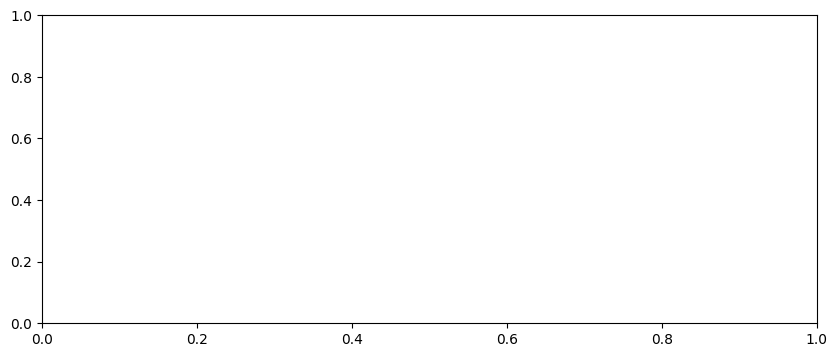

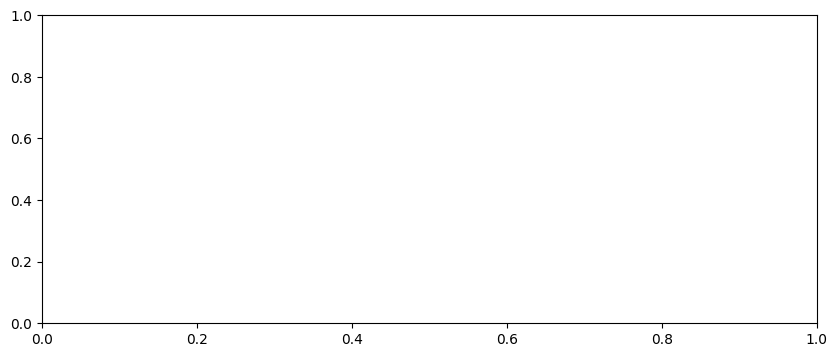

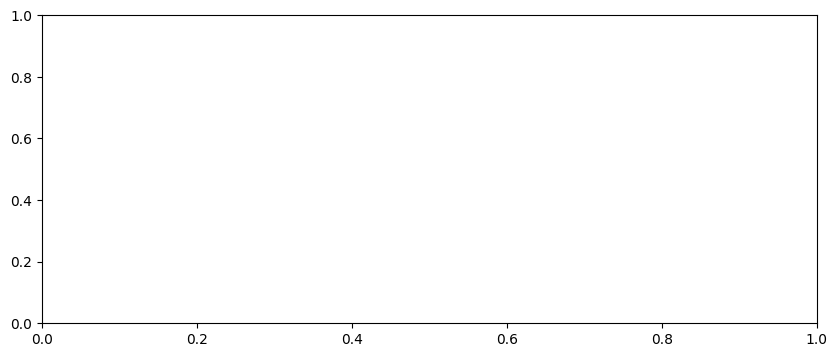

In [302]:
interactive_histogram(df_LP.head(5))